# Test task #1

To achieve the desired result, we can perform the following steps in SQL:

* Aggregate the bet_win_sum_by_day table to get the total bet_sum and win_sum for each system_id, game_id, and currency for the months of August and September 2022. We will group by the system_id, game_id, and the month part of the date field.

* Count the distinct number of user_id from the events table for the same system_id and currency for the months of August and September 2022. We will group by the system_id and the month part of the date field.

* Join the aggregated results from both tables on system_id and the month part of the date field to get the final result.

### Here is the SQL query that performs these steps:

``` mysql
SELECT
    TO_CHAR(b.date, 'YYYY-MM') AS month_date,
    b.system_id,
    b.game_id,
    b.bet_sum,
    b.win_sum,
    e.user_count
FROM
    (SELECT
        system_id,
        game_id,
        currency,
        DATE_TRUNC('month', date) AS month,
        SUM(bet_sum) AS bet_sum,
        SUM(win_sum) AS win_sum
    FROM
        bet_win_sum_by_day
    WHERE
        date >= '2022-08-01' AND date <= '2022-09-30'
    GROUP BY
        system_id,
        game_id,
        currency,
        month) b
JOIN
    (SELECT
        system_id,
        currency,
        DATE_TRUNC('month', date) AS month,
        COUNT(DISTINCT user_id) AS user_count
    FROM
        events
    WHERE
        date >= '2022-08-01' AND date <= '2022-09-30'
    GROUP BY
        system_id,
        currency,
        month) e
ON
    b.system_id = e.system_id AND
    b.currency = e.currency AND
    b.month = e.month
ORDER BY
    month_date,
    b.system_id,
    b.game_id;|
```

## Test task #2

In [28]:
import pandas as pd
df = pd.read_csv('Test_dataset.csv')

In [29]:
df

,date,system_id,game_id,bet_sum,round_count
0,9/1/2022,1,100,100,10
1,9/2/2022,1,100,50,15
2,9/3/2022,1,100,250,23
3,9/4/2022,1,100,300,14
4,9/5/2022,1,100,45,10
...,...,...,...,...,...
162,9/26/2022,2,102,142,20
163,9/27/2022,2,102,145,20
164,9/28/2022,2,102,187,"24,5"
165,9/29/2022,2,102,144,21


### 1) Calculation average bet for each system and each game in it:

In [30]:
average_bets = df.groupby(['system_id', 'game_id'])['bet_sum'].mean().reset_index()
average_bets.rename(columns={'bet_sum': 'average_bet'}, inplace=True)
average_bets

,system_id,game_id,average_bet
0,1,100,120.933333
1,1,101,145.933333
2,1,102,110.566667
3,2,100,157.058824
4,2,101,168.566667
5,2,102,156.833333


### 2) Finding a game and a system with biggest bet sum and avg bet:

In [32]:
# Find the game and system with the biggest total bet sum
max_bet_sum = df.groupby(['system_id', 'game_id'])['bet_sum'].sum().reset_index()
max_bet_sum_game_system = max_bet_sum.loc[max_bet_sum['bet_sum'].idxmax()]

# Find the game and system with the biggest average bet
max_avg_bet = df.groupby(['system_id', 'game_id'])['bet_sum'].mean().reset_index()
max_avg_bet_game_system = max_avg_bet.loc[max_avg_bet['bet_sum'].idxmax()]

### The game and system with the biggest total bet sum:

In [34]:
max_bet_sum_game_system

system_id       2
game_id       101
bet_sum      5057
Name: 4, dtype: int64

### The game and system with the biggest average bet:

In [35]:
max_avg_bet_game_system

system_id      2.000000
game_id      101.000000
bet_sum      168.566667
Name: 4, dtype: float64

### Investigation of an anomal activity in data.

In [40]:
# Calculate IQR for 'bet_sum'
Q1_bet = df['bet_sum'].quantile(0.25)
Q3_bet = df['bet_sum'].quantile(0.75)
IQR_bet = Q3_bet - Q1_bet
outlier_threshold_bet = 1.5 * IQR_bet

# Calculate IQR for 'round_count' if it's numeric
Q1_round = df['round_count'].quantile(0.25)
Q3_round = df['round_count'].quantile(0.75)
IQR_round = Q3_round - Q1_round
outlier_threshold_round = 1.5 * IQR_round

# Identify outliers
bet_outliers = df[(df['bet_sum'] < (Q1_bet - outlier_threshold_bet)) | (df['bet_sum'] > (Q3_bet + outlier_threshold_bet))]
round_outliers = df[(df['round_count'] < (Q1_round - outlier_threshold_round)) | (df['round_count'] > (Q3_round + outlier_threshold_round))]

# Display outliers
'Bet Outliers:', bet_outliers, 'Round Count Outliers:', round_outliers

('Bet Outliers:',
          date  system_id  game_id  bet_sum  round_count
 33 2022-09-04          1      101      325         19.0
 49 2022-09-20          1      101      325         19.0
 57 2022-09-28          1      101      325         37.0,
 'Round Count Outliers:',
          date  system_id  game_id  bet_sum  round_count
 76 2022-09-17          1      102       60         -2.0)

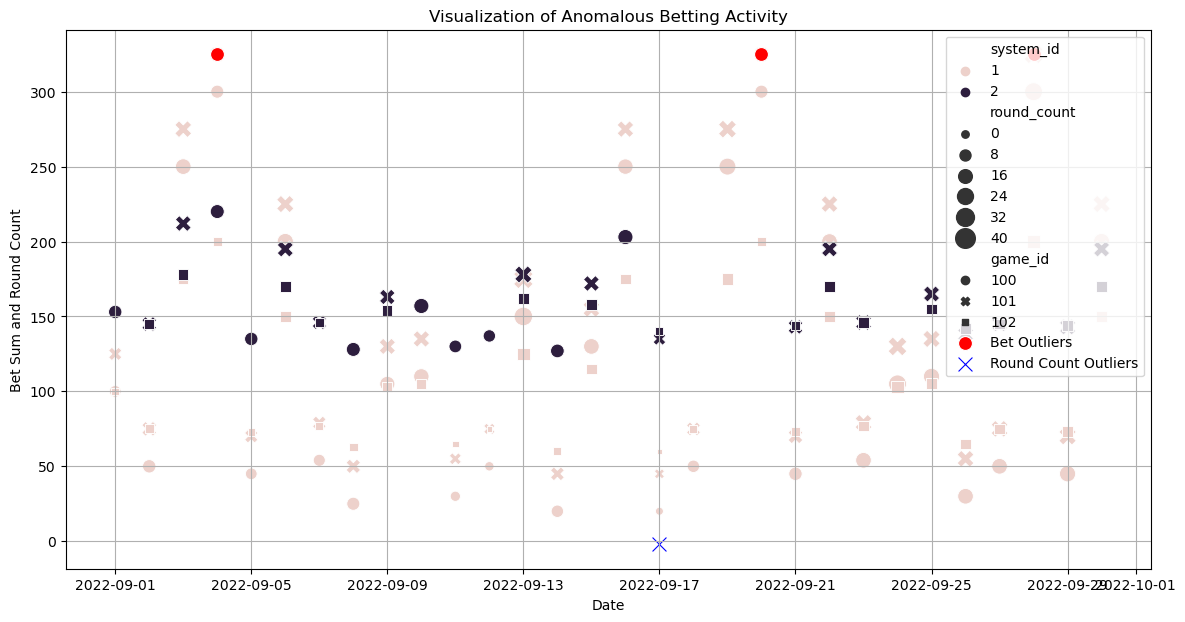

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert date to datetime for plotting
df['date'] = pd.to_datetime(df['date'])

# Create a scatter plot for bet sums highlighting the outliers
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df, x='date', y='bet_sum', hue='system_id', style='game_id', size='round_count', sizes=(20, 200))

# Highlight outliers with a different color
sns.scatterplot(data=bet_outliers, x='date', y='bet_sum', color='red', label='Bet Outliers', s=100)
sns.scatterplot(data=round_outliers, x='date', y='round_count', color='blue', label='Round Count Outliers', s=100, marker='x')

plt.title('Visualization of Anomalous Betting Activity')
plt.xlabel('Date')
plt.ylabel('Bet Sum and Round Count')
plt.legend()
plt.grid(True)
plt.show()